In [20]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'..')
import tqdm
import requests
import math
import zipfile
import dask
import socceraction.spadl.api as spadl
import socceraction.atomic.atomic_spadl as atomic_spadl
import socceraction.atomic.features as fs
import socceraction.atomic.labels as lab

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datafolder = "../data/dask"
statsbombzip = os.path.join(datafolder, "statsbomb-open-data.zip")
statsbombroot = os.path.join(datafolder, "statsbomb-root")

statsbomb_json =  os.path.join(datafolder,"statsbomb")
statsbomb_h5 = os.path.join(datafolder,"statsbomb.h5")
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created ")

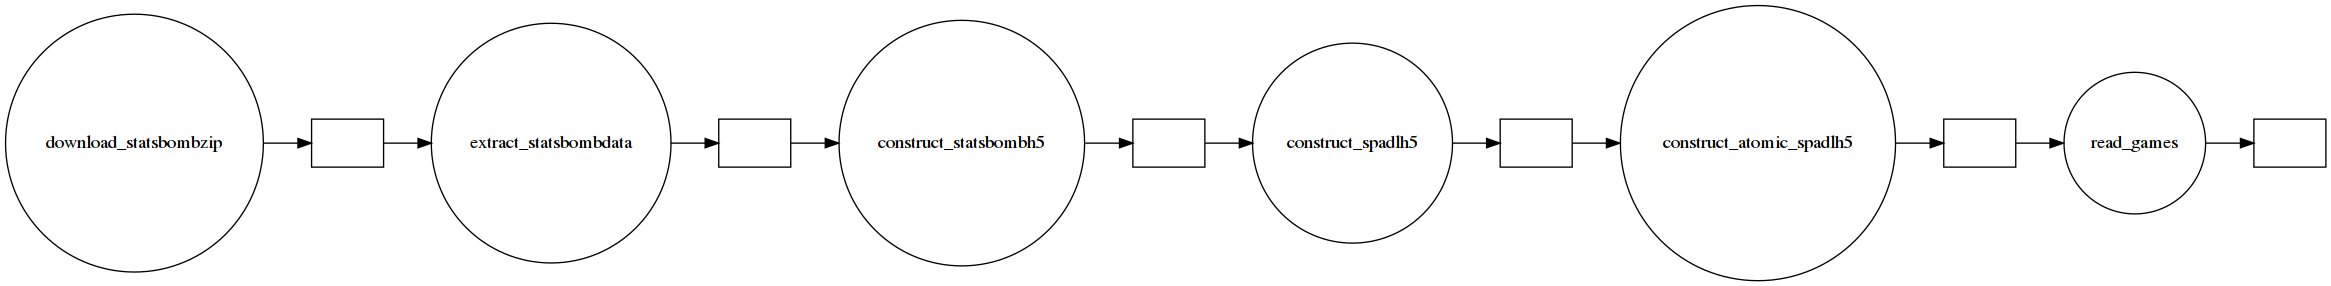

In [22]:

url = "https://github.com/statsbomb/open-data/archive/master.zip"

@dask.delayed
def download_statsbombzip():
    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    block_size = 1024 * 1024
    with open(statsbombzip, "wb") as f:
        datastream = tqdm.tqdm(r.iter_content(block_size),unit="MB")
        for data in datastream:
            f.write(data)
    return statsbombzip

@dask.delayed
def extract_statsbombdata(statsbombzip):
    with zipfile.ZipFile(statsbombzip, 'r') as zipObj:
        zipObj.extractall(statsbombroot)
    return statsbombroot

@dask.delayed
def construct_statsbombh5(statsbombroot):
    statsbomb_json = os.path.join(statsbombroot, "open-data-master", "data")
    spadl.statsbombjson_to_statsbombh5(statsbomb_json,statsbomb_h5)
    return statsbomb_h5

@dask.delayed
def construct_spadlh5(statsbomb_h5):
    spadl.statsbombh5_to_spadlh5(statsbomb_h5,spadl_h5)
    return spadl_h5

@dask.delayed
def construct_atomic_spadlh5(ready):
    atomic_spadl.add_atomic_actions(spadl_h5)
    return spadl_h5


@dask.delayed
def read_games(done):
    games = pd.read_hdf(spadl_h5,"games")
    games = games[games.competition_name == "Fifa World Cup"]
    print("nb of games:", len(games))
    return games


xfns = [fs.actiontype,
   fs.actiontype_onehot,
   fs.bodypart,
   fs.bodypart_onehot,
   fs.goalscore,
   fs.location,
   fs.polar,
   fs.direction,
   fs.team,
   fs.time,
   fs.time_delta
  ]

@dask.delayed
def get_features(spadlstore,xfns,game):
    actions = (spadlstore[f"atomic_actions/game_{game.game_id}"]
        .merge(actiontypes,how="left")
        .merge(bodyparts,how="left")
        .reset_index(drop=True)
    )
    gamestates = fs.gamestates(actions,3)
    gamestates = fs.play_left_to_right(gamestates,game.home_team_id)

    X = pd.concat([fn(gamestates) for fn in xfns],axis=1)
    return X
    #X.to_hdf(features_h5,f"game_{game.game_id}")

def get_labels(spadlstore,game_id):
    pass
    
        
def construct_features(games):
    with pd.HDFStore(spadl_h5,"r") as spadlstore:
        for game in tqdm.tqdm(list(games.itertuples()),
                              desc=f"Generating and storing features in {features_h5}"):
            f = get_features(spadlstore)
        

def construct_labels(games):
    pass
    

#url = "https://github.com/statsbomb/open-data/archive/master.zip"

z = download_statsbombzip()
d = extract_statsbombdata(z)
sbh5 = construct_statsbombh5(d)
sph5 = construct_spadlh5(sbh5)
sph5 = construct_atomic_spadlh5(sph5)
games = read_games(sph5)
games.visualize(rankdir="LR")